<a href="https://colab.research.google.com/github/HumanRtrUni/ml_class_assignment/blob/main/cse23247_ml_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving heart_cleveland_upload.csv to heart_cleveland_upload.csv
Dataset loaded. Shape: (297, 14)
Detected target column: condition
Numeric features used for experiments: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

A1 completed: Linear Regression model trained using single feature -> age

A2 results (Single-feature Linear Regression):
Train Metrics -> {'MSE': 0.23051990150734628, 'RMSE': np.float64(0.48012488115837765), 'MAPE(%)': np.float64(2305199038.125453), 'R2': 0.07195582369795483}
Test  Metrics -> {'MSE': 0.25855185591427754, 'RMSE': np.float64(0.5084799464229416), 'MAPE(%)': np.float64(2570069873.4394493), 'R2': -0.03882442108415063}

A3 completed: Linear Regression model trained using ALL numeric features.

A3 results (All-features Linear Regression):
Train Metrics -> {'MSE': 0.10488913156971702, 'RMSE': np.float64(0.32386591603581416), 'MAPE(%)': np.float64(1208290740.415851), 'R2': 0.5777295275846162}
Test 

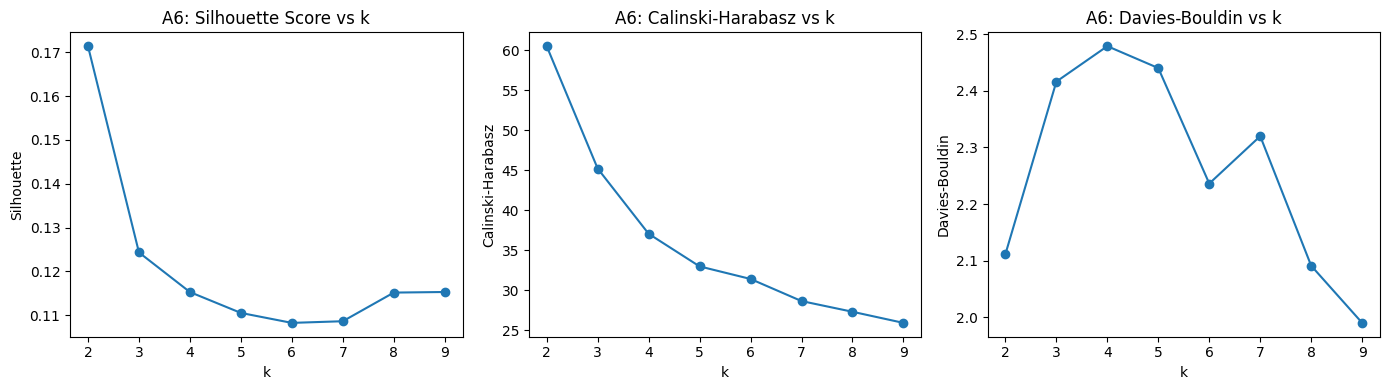


A7 completed: Inertia computed for k in [2, 19].


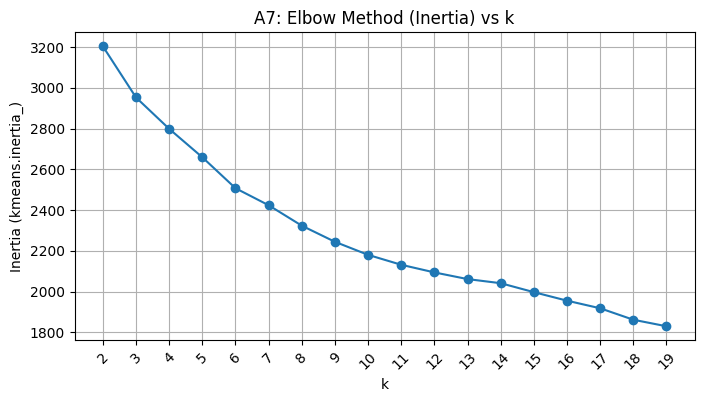

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from google.colab import files
import warnings
warnings.filterwarnings("ignore")


def load_dataset(preferred_path='/mnt/data/heart_cleveland_upload.csv'):
    """
    loadin the dataset
    If not present, open the Colab upload widget.
    Returns: pandas.DataFrame
    """
    try:
        df = pd.read_csv(preferred_path)
        return df
    except Exception:
        uploaded = files.upload()
        fname = list(uploaded.keys())[0]
        df = pd.read_csv(fname)
        return df

def detect_target_column(df):
    """
    Heuristic to find the target column.
    Preference order: 'target' -> 'num' -> 'diagnosis' -> 'class' -> last column.
    Returns: column_name (string)
    """
    cols_lower = [c.lower() for c in df.columns]
    candidates = ['target', 'num', 'diagnosis', 'class', 'label']
    for cand in candidates:
        if cand in cols_lower:
            return df.columns[cols_lower.index(cand)]
    # fallback: if last column numeric and appears like a label, choose last column
    last_col = df.columns[-1]
    if pd.api.types.is_numeric_dtype(df[last_col]):
        return last_col
    # otherwise just return last column
    return last_col

def preprocess_for_modeling(df, target_col):
    """
    Basic preprocessing:
    - Drop rows with NA
    - Separate X (features) and y (target)
    - Keep only numeric features (drop non-numeric) for simplicity
    Returns: X (DataFrame), y (Series)
    """
    df_clean = df.dropna().copy()
    y = df_clean[target_col]
    X = df_clean.drop(columns=[target_col])
    # Keep only numeric columns for these experiments
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_numeric = X[numeric_cols].copy()
    return X_numeric, y

def split_data(X, y, test_size=0.2, random_state=42):
    """Train-test split helper"""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def train_linear_regression(X_train, y_train):
    """Train LinearRegression on provided X_train, y_train. Return fitted model."""
    model = LinearRegression().fit(X_train, y_train)
    return model

def predict_model(model, X):
    """Return predicted values for X using provided model."""
    return model.predict(X)

def regression_metrics(y_true, y_pred):
    """Compute MSE, RMSE, MAPE (as %), R2. Return dict. MAPE handled with small-epsilon to avoid div-by-zero."""
    eps = 1e-8
    mse = mean_squared_error(y_true, y_pred)
    # Calculate RMSE by taking the square root of MSE
    rmse = np.sqrt(mse)
    # MAPE in percent; handle zeros by adding eps where needed
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    mape = np.mean(np.abs((y_true - y_pred) / denom)) * 100.0
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAPE(%)': mape, 'R2': r2}

def prepare_for_clustering(X):
    """
    Prepare feature matrix for KMeans:
    - Keep numeric columns
    - Standardize features (mean=0, std=1)
    Returns scaled numpy array and scaler instance
    """
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_num = X[numeric_cols].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_num)
    return X_scaled, numeric_cols, scaler

def fit_kmeans(X_array, k, random_state=42):
    """Fit KMeans and return fitted model"""
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X_array)
    return kmeans

def clustering_metrics(X_array, labels):
    """Compute Silhouette, Calinski-Harabasz, Davies-Bouldin. Return dict"""
    # Silhouette requires at least 2 clusters and less than n samples clusters
    sil = silhouette_score(X_array, labels) if len(np.unique(labels)) > 1 else np.nan
    ch = calinski_harabasz_score(X_array, labels) if len(np.unique(labels)) > 1 else np.nan
    db = davies_bouldin_score(X_array, labels) if len(np.unique(labels)) > 1 else np.nan
    return {'Silhouette': sil, 'Calinski-Harabasz': ch, 'Davies-Bouldin': db}

def evaluate_k_range(X_array, k_min=2, k_max=9):
    """
    For k in [k_min, k_max] (inclusive), fit KMeans and compute metrics + inertia.
    Returns a pandas DataFrame with columns: k, Silhouette, Calinski-Harabasz, Davies-Bouldin, Inertia
    """
    results = {'k': [], 'Silhouette': [], 'Calinski-Harabasz': [], 'Davies-Bouldin': [], 'Inertia': []}
    for k in range(k_min, k_max + 1):
        kmeans = fit_kmeans(X_array, k)
        labels = kmeans.labels_
        metrics = clustering_metrics(X_array, labels)
        results['k'].append(k)
        results['Silhouette'].append(metrics['Silhouette'])
        results['Calinski-Harabasz'].append(metrics['Calinski-Harabasz'])
        results['Davies-Bouldin'].append(metrics['Davies-Bouldin'])
        results['Inertia'].append(kmeans.inertia_)
    return pd.DataFrame(results)

def elbow_inertia(X_array, k_min=2, k_max=19):
    """
    Compute inertia (distortions) for k in [k_min, k_max] to make elbow plot (A7).
    Returns two lists: ks and inertias.
    """
    ks = list(range(k_min, k_max + 1))
    inertias = []
    for k in ks:
        kmeans = fit_kmeans(X_array, k)
        inertias.append(kmeans.inertia_)
    return ks, inertias

# 3. MAIN SECTION (calls the functions for A1..A7 in order; prints only here)

# Load dataset
df = load_dataset()   # tries /mnt/data/... first then upload widget if missing
print("Dataset loaded. Shape:", df.shape)

# Detect target column
target_col = detect_target_column(df)
print("Detected target column:", target_col)

# Preprocess: keep numeric features and target, drop NAs
X_all, y_all = preprocess_for_modeling(df, target_col)
print("Numeric features used for experiments:", X_all.columns.tolist())

# Train-test split (for regression tasks)
X_train, X_test, y_train, y_test = split_data(X_all, y_all, test_size=0.2, random_state=42)

#A1. If your project deals with a regression problem, please use one attribute of your dataset
#(X_train) along with the target values (y_train) for training a linear regression model. Sample code
#suggested below.

feature_one = X_all.columns[0]
X_train_a1 = X_train[[feature_one]].copy()
X_test_a1 = X_test[[feature_one]].copy()

# Train model (A1) - training only
model_a1 = train_linear_regression(X_train_a1, y_train)
print("\nA1 completed: Linear Regression model trained using single feature ->", feature_one)

#A2. Calculate MSE, RMSE, MAPE and R2 scores for prediction made by the trained model in A1.
#Perform prediction on the test data and compare the metric values between train and test set.
y_train_pred_a1 = predict_model(model_a1, X_train_a1)
y_test_pred_a1 = predict_model(model_a1, X_test_a1)
metrics_train_a1 = regression_metrics(np.array(y_train), np.array(y_train_pred_a1))
metrics_test_a1 = regression_metrics(np.array(y_test), np.array(y_test_pred_a1))

print("\nA2 results (Single-feature Linear Regression):")
print("Train Metrics ->", metrics_train_a1)
print("Test  Metrics ->", metrics_test_a1)

#A3. Repeat the exercises A1 and A2 with more than one attribute or all attributes.
model_a3 = train_linear_regression(X_train, y_train) # Added this line which was missing
print("\nA3 completed: Linear Regression model trained using ALL numeric features.")

# Compute metrics for A3
y_train_pred_a3 = predict_model(model_a3, X_train)
y_test_pred_a3 = predict_model(model_a3, X_test)
metrics_train_a3 = regression_metrics(np.array(y_train), np.array(y_train_pred_a3))
metrics_test_a3 = regression_metrics(np.array(y_test), np.array(y_test_pred_a3))

print("\nA3 results (All-features Linear Regression):")
print("Train Metrics ->", metrics_train_a3)
print("Test  Metrics ->", metrics_test_a3)

#A4. Perform k-means clustering on your data. Please remove / ignore the target variable for
#performing clustering. Sample code suggested below.

X_cluster_array, cluster_feature_names, cluster_scaler = prepare_for_clustering(X_all)
k_a4 = 2
kmeans_a4 = fit_kmeans(X_cluster_array, k=k_a4)
print(f"\nA4 completed: KMeans fitted with k={k_a4}.")
# Print cluster sizes (counts) as basic info (allowed in main)
unique, counts = np.unique(kmeans_a4.labels_, return_counts=True)
cluster_counts = dict(zip(unique.tolist(), counts.tolist()))
print("Cluster counts (k=2):", cluster_counts)


# A5. For the clustering done in A4, calculate the: (i) Silhouette Score, (ii) CH Score and (iii) DB Index.

metrics_a5 = clustering_metrics(X_cluster_array, kmeans_a4.labels_)
print(f"\nA5 results (Clustering metrics for k={k_a4}):")
print(metrics_a5)

# A6. Perform k-means clustering for different values of k. Evaluate the above scores for each k value.
#Make a plot of the values against the k value to determine the optimal cluster count
kmin_a6 = 2
kmax_a6 = 9  # you can extend this if you like
df_k_evaluation = evaluate_k_range(X_cluster_array, k_min=kmin_a6, k_max=kmax_a6)
print(f"\nA6 completed: Clustering metrics evaluated for k in [{kmin_a6}, {kmax_a6}].")
print(df_k_evaluation)

# Plot A6 metrics vs k
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(df_k_evaluation['k'], df_k_evaluation['Silhouette'], marker='o')
plt.title("A6: Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette")

plt.subplot(1,3,2)
plt.plot(df_k_evaluation['k'], df_k_evaluation['Calinski-Harabasz'], marker='o')
plt.title("A6: Calinski-Harabasz vs k")
plt.xlabel("k"); plt.ylabel("Calinski-Harabasz")

plt.subplot(1,3,3)
plt.plot(df_k_evaluation['k'], df_k_evaluation['Davies-Bouldin'], marker='o')
plt.title("A6: Davies-Bouldin vs k")
plt.xlabel("k"); plt.ylabel("Davies-Bouldin")

plt.tight_layout()
plt.show()

# A7. Using elbow plot, determine the optimal k value for k-means clustering. Use below code.
kmin_a7 = 2
kmax_a7 = 19
ks_a7, inertias_a7 = elbow_inertia(X_cluster_array, k_min=kmin_a7, k_max=kmax_a7)
print(f"\nA7 completed: Inertia computed for k in [{kmin_a7}, {kmax_a7}].")

# Plot Elbow curve
plt.figure(figsize=(8,4))
plt.plot(ks_a7, inertias_a7, marker='o')
plt.title("A7: Elbow Method (Inertia) vs k")
plt.xlabel("k")
plt.ylabel("Inertia (kmeans.inertia_)")
plt.xticks(ks_a7, rotation=45)
plt.grid(True)
plt.show()